# 1. Import libraries

In [1]:
import json
from datetime import datetime
import time
import requests
import pandas as pd
import regex as re # regex for 'hangul'(korean) component
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud

%matplotlib inline

>It should be noted that **'regex'** module is imported here instead of the standard library **re** module. This **'regex'** module is backwards-compatible with the standard **'re'** module, but offers additional functionality. Since the K-pop reddit posts include Korean characters, the **'regex'** module can process the more languages compare to **'re'** module.

# 2. Import DataFrame

Let's import the Data and filled the empty cells with text 'blank'.

In [2]:
df = pd.read_csv('../dataset/text.csv')

In [3]:
df.isnull().sum()

Year           0
text          59
subchannel     0
class          0
dtype: int64

In [4]:
df = df.fillna('blank')

# 3. Text Preprocessing

## 3.1 Drop the duplicates

In [5]:
df.shape

(141887, 4)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(139721, 4)

There are 2166 duplicates in the data. 

## 3.2 Remove Numbers, Punctuations, Stop words and Lemmatize the text

Right now, our text is one long string, we have to break the strings into individual words. The pre-processing follow the agenda below: 

- Use the Regular Expression to remove numbers and punctuations
- Convert the text in lowercase and split the strings into individual words
- Remove English stop words
- Remove frequently appeared English word that is not meaningful
- Lemmatize the text allow us to combine similar forms of the same word.

### 3.2.1 Define a function 

In [8]:
def clean_words(raw_text):       
    letters_only = re.sub("[^a-zA-Z\p{Hangul}\p{Han}]", " ", raw_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    extra_stops = set(['th','kpop','k','pop','music','album','would','amp','deleted','removed','gt'])
    nostop_words = [w for w in words if not w in stops]
    meaningful_words = [w for w in nostop_words if not w in extra_stops]
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    return(" ".join(lem_words))

### 3.2.2 Apply function to the `text` and `subchannel`

In [9]:
print("Cleaning and parsing the reddit text...")
j = 0
clean_text = []
for text in df['text']:
    clean_text.append(clean_words(str(text)))
    if (j+1) % 20000 == 0:
        print(f'text{j+1} of {len(df["text"])}.')
    j += 1

Cleaning and parsing the reddit text...
text20000 of 139721.
text40000 of 139721.
text60000 of 139721.
text80000 of 139721.
text100000 of 139721.
text120000 of 139721.


In [10]:
print("Cleaning and parsing the subchannel title...")
j = 0
clean_subchannel = []
for sub in df['subchannel']:
    clean_subchannel.append(clean_words(str(sub)))
    if (j+1) % 20000 == 0:
        print(f'text{j+1} of {len(df["subchannel"])}.')
    j += 1

Cleaning and parsing the subchannel title...
text20000 of 139721.
text40000 of 139721.
text60000 of 139721.
text80000 of 139721.
text100000 of 139721.
text120000 of 139721.


Replace the `text` and `subchannel`columns with the clean and tokenized text.

In [11]:
df['text'] = clean_text
df['subchannel'] = clean_subchannel

After process the text data, there might be duplicates in the DataFrame, so we apply `drop_duplicates` again.

In [12]:
df.drop_duplicates(inplace=True)
df.shape

(133448, 4)

We want to keep the raw text's (the text before pre-processing) index same as the index in the `df` so that we can trace back to the original text to verify the model results. 

In [13]:
raw_text = pd.read_csv('../dataset/text.csv')

In [14]:
raw_text.loc[df.index].to_csv('../dataset/raw_text.csv',index=None)

# 4. Exploratory data analysis

CountVectorizer will transform the lists of the cleaned text above into features that we can start to conduct feature exploration and analysis. It will create columns (also known as vectors), where each column counts how many times each word is observed.

In [15]:
vect = CountVectorizer()
subchannel_term = vect.fit_transform(df['subchannel'])
subchannel = pd.DataFrame(subchannel_term.toarray(), columns=vect.get_feature_names())
subchannel.insert(0, 'target_class', df['class'].values,)

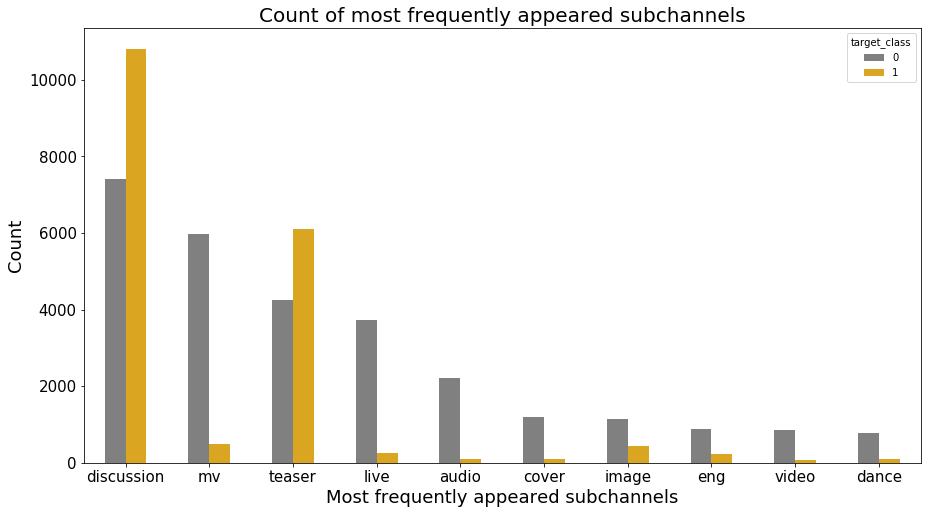

In [16]:
subchannel.groupby('target_class').sum().T.sort_values(0, ascending=False).head(10).plot.bar(color=['grey', "goldenrod"],figsize = (15,8));
plt.xticks(fontsize=15, rotation=0);
plt.yticks(fontsize=15);
plt.xlabel('Most frequently appeared subchannels', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Count of most frequently appeared subchannels',fontsize =20);

The figure above shows the the top ten frequently appeared subchannel names are "Discussion", "MV", "Teaser", "Live", "Audio", "Cover", "Image", "Eng", "Video" and "Dance" during 2013 to 2016. We can observe that the number of posts in each subchannels are quite different between "Pre-mature" and "Golden" Era except in "Discussion" and "Teaser" subchannles.

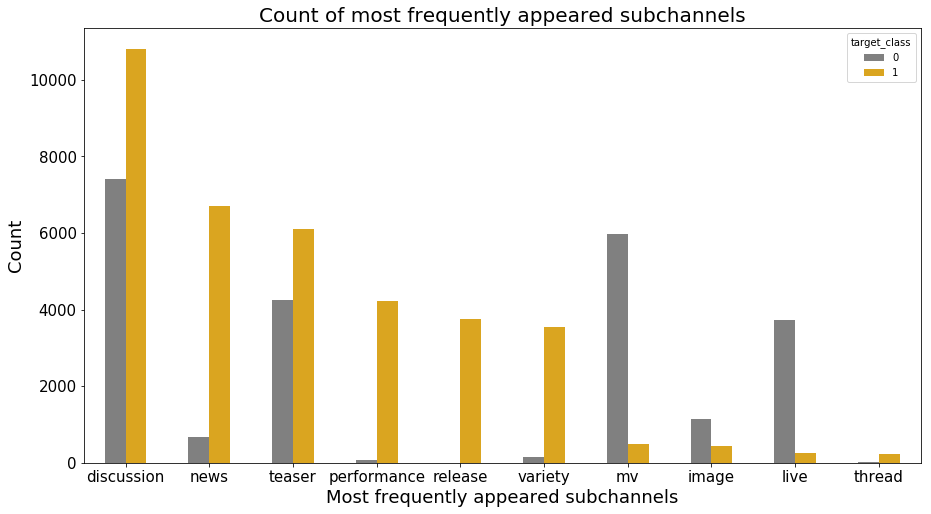

In [17]:
subchannel.groupby('target_class').sum().T.sort_values(1, ascending=False).head(10).plot.bar(color=["grey", 'goldenrod'],figsize = (15,8));
plt.xticks(fontsize=15, rotation=0);
plt.yticks(fontsize=15);
plt.xlabel('Most frequently appeared subchannels', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Count of most frequently appeared subchannels',fontsize =20);

The figure above shows the the top ten frequently appeared subchannel name are "Discussion", "News", "Teaser", "Performance", "Release", "Variety", "MV", "Image", "Live" and "Thread" during 2017 to 2018. Interestingly, the number of posts in 'News','Performance','Release', and 'Variety' subchannels increased dramatically in recent years. Social media makes it a lot easier to find and watch Korean variety shows or performances that K-pop idols appeared on, and the posts are much more updated than before.

In [18]:
news_list = df[(df['subchannel'] == 'news')]
news_list.reset_index(drop=True, inplace = True)

In [19]:
news_terms = vect.fit_transform(news_list['text'])
news_data = pd.DataFrame(news_terms.toarray(), columns=vect.get_feature_names())
news_data.insert(0, 'target_class', news_list['class'].values)

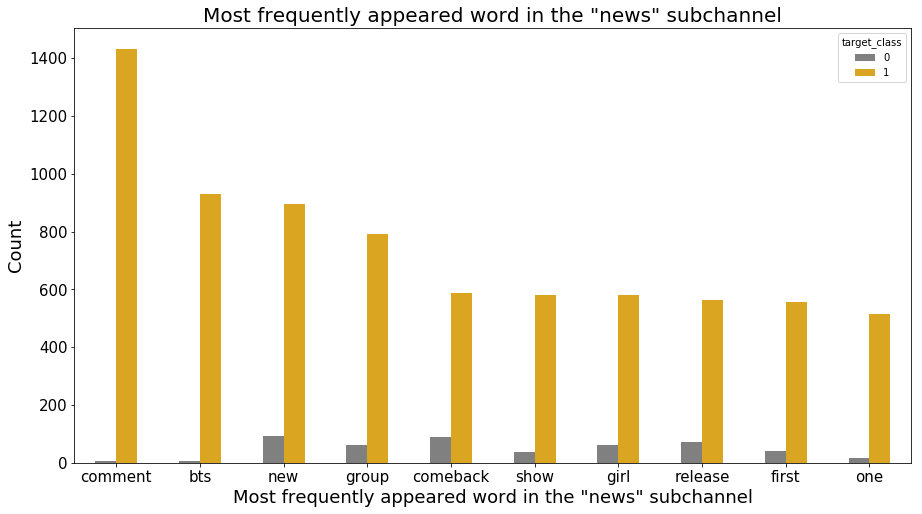

In [20]:
news_data.groupby('target_class').sum().T.sort_values(1, ascending=False).head(10).plot.bar(color=['grey', "goldenrod"],figsize = (15,8));
plt.xticks(fontsize=15, rotation=0);
plt.yticks(fontsize=15);
plt.xlabel('Most frequently appeared word in the "news" subchannel', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Most frequently appeared word in the "news" subchannel',fontsize =20);

Unsurprisingly, the second frequently appeared word in the news subchannel is the Korean Boyband "BTS".  

In [21]:
discussion_list = df[(df['subchannel'] == 'discussion')]
discussion_list.reset_index(drop=True, inplace = True)

In [22]:
discussion_terms = vect.fit_transform(discussion_list['text'])
discussion_data = pd.DataFrame(discussion_terms.toarray(), columns=vect.get_feature_names())
discussion_data.insert(0, 'target_class', discussion_list['class'].values)

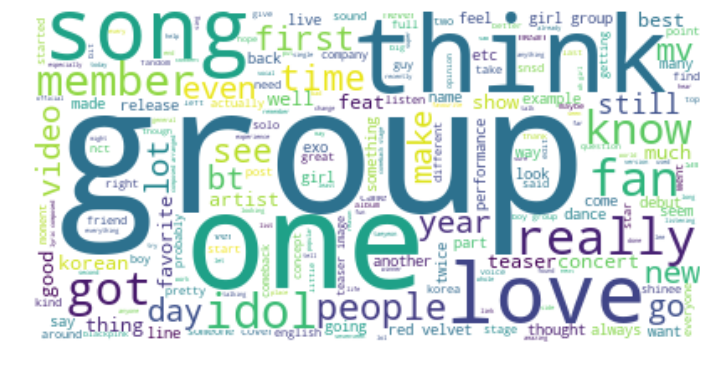

In [23]:
wordcloud = WordCloud(background_color="white").generate(' '.join(discussion_list['text']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looking at the text in the "Discussion" subchannel in 2017 and 2018, the most frequently appeared word in the "discussion" subchannel is the word "group", which make sense since K-pop artists are usually a group. The second most frequently appeared word is "one". This might be due to the Korean Popular Variety shows "Produce 101" and "Produce 48" which broadcast in 2017 and 2018 produced by the Korean Entertainment compay CJ ENM. "Wanna One" and "IZ\*ONE" are two groups produced from these shows. CJ ENM's Kpop idol production ability has been proven. Every album released by "Wanna One" and "IZ\*One" attains extraordinary success. This could be a reason that the "One" is frequently appeared in "Discussion" subchannel.

# 5. Save the DataFrame for further use

In [24]:
#df.to_csv('../dataset/kpop.csv',index=None)